In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const
import pandas as pd
import xarray as xr
import seaborn as sns

In [2]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)
chirpM = 26*u.Msun
rho_crit = (3/8/np.pi) * H0**2 /G # has dimensions of density (mass/volume)

fref = 25. /u.s
OmegaGW_limit = 4.8e-8
Rate = 53.2 /(u.Gpc**3 * u.year)
t_obs = 1.5 *u.year

#mass distribution parameters
m_min = 6.7 #minimum allowed component mass
m_max = 41.9 #maximum allowed component mass
gamma = -1.4 #power law spectral index for individual component masses
beta_q = 4 #spectral index for selection function: f(q) \prop q^beta_q

## Horizon Distance of a Euclidian Universe 

$$ r_{\text{hor}} = \frac{9\Omega_{\text{ref}} H_0^2 c^3}{8 \mathcal{R}} (f_{\text{ref}})^{-2/3} ( G \pi \mathcal{M})^{-5/3} $$ 

Where $\mathcal{R}$ is the rate density of events. Here we have assumed it to be the local merger rate $\mathcal{R}_0$. 

In [4]:
def r_hor(H0,c,G,Mchirp,Omega,fref,R):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0**2 *(c**3)
    
    rhor = (9/(8 * R)) * Hoc * GpiM53 * Omegaf
    return rhor

In [5]:
r = r_hor(H0,c,G,chirpM,OmegaGW_limit,fref,Rate)
r.to(u.Gpc)

<Quantity 87.6129624038377 Gpc>

In [6]:
hubble_dist = c/H0
(r/hubble_dist).to(u.m/u.m)

<Quantity 19.84346166313644>

In [39]:
#chirp mass for two 30 solar mass BHs
m = 35 * u.Msun
M53 = m*m*(m+m)**(-1./3)
M53**(3./5)

<Quantity 30.46926972 solMass>

In [26]:
# if you want to integrate over observing time instead of the age of the U (this no longer makes sense)
def r_hor_tobs(H0,c,G,Mchirp,Omega,fref,R,tobs):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0 *(c**3)
    N = R * tobs
    
    rhor = (9./(8 *N)) * Hoc * GpiM53 * Omegaf
    return rhor

In [21]:
r = r_hor_tobs(H0,c,G,chirpM,OmegaGW_limit,fref,Rate,t_obs)
r.to(u.Gpc)

<Quantity 841112156663.8446 Gpc>

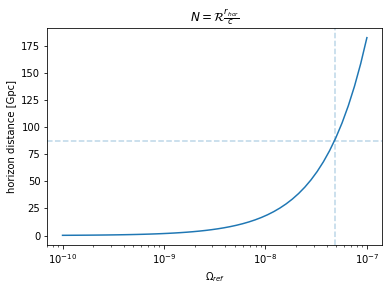

In [9]:
#plot them
possible_omegas = np.logspace(-10,-7)
# --- t= age of U ---#
plt.plot(possible_omegas,r_hor(H0,c,G,chirpM,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit,linestyle='--',alpha=0.3)
plt.axhline(87.6,linestyle='--',alpha=0.3)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'$N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()
# #--- t = t_obs ---#
# plt.plot(possible_omegas,r_hor_tobs(H0,c,G,chirpM,possible_omegas,fref,Rate,t_obs).to(u.Gpc))
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel(r'$\Omega_{ref}$')
# plt.ylabel('horizon distance [Gpc]')
# plt.title(r'$N = \mathcal{R}t_{obs}$')
# plt.show()

### Adding in a mass distribution

$$\rho_c c^2 \Omega_{GW}(f) =  r_{hor} \frac{H_0}{c} \frac{(f G \pi)^{2/3}}{3 (2)^{1/3}} \int d t \frac{\mathcal{R}_0 (2\gamma +1)}{m_{max}^{2\gamma +1} - m_{min}^{2\gamma +1}} [\frac{m_{max}^{2\gamma +8/3} - m_{min}^{2\gamma +8/3}}{(2\gamma +8/3)}] $$

In [14]:
#this assumes equal masses and a power law for each component mass
def r_hor_marg_Mchirp(H0,c,G,Omega,fref,R0):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    Gpi53 = np.power(np.pi,-5./3)
    Hoc = H0**2 * (c**3)
    
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power))    
    RofM = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max*G,5./3)-np.power(m_min,power)*np.power(m_min*G,5./3)) \
    / (power+5./3)
    #(you have to do some finegling to get the 5/3 thing to cancel units with the mass in G properly but this does the trick^)
    
    rhor = (9./(8 *RofM)) * Hoc * Gpi53 * Omegaf
    return rhor

In [15]:
r_hor_marg_Mchirp(H0,c,G,OmegaGW_limit,fref,Rate).to(u.Gpc)

<Quantity 348.01806764493966 Gpc>

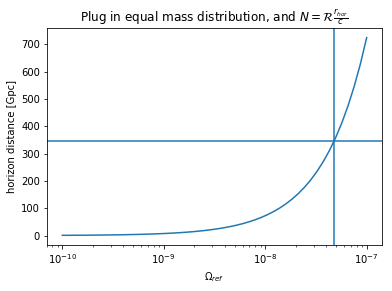

In [16]:
plt.plot(possible_omegas,r_hor_marg_Mchirp(H0,c,G,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit)
plt.axhline(348.0)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'Plug in equal mass distribution, and $N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()

## Putting Limits on FLRW parameters

$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \mathcal{R_0} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{1/3} H(z)} \text{(massfac)(z-evo)} $

where $ \text{massfac} = \int_0^\infty \text{d}\mathcal{M} \frac{\text{d}\mathcal{R}(\mathcal{M},z)}{\text{d}\mathcal{M}} \mathcal{M}^{5/3}$ accounts for the mass distribution of binaries and $ \text{z-evo} = \mathcal{C}(\alpha,\beta,z_p) \frac{(1+z)^{\alpha}}{1 + (\frac{1+z}{1+z_p})^{\alpha+\beta}} $ is the redshift evolution of the merger rate.

In [3]:
#mass distributions
def one_chirp_mass():
    '''instead of a distribution in mass, we just pretend all systems have equal mass components 
    and chirp mass 30 Msun'''
    Mchirp = 30
    massfac = np.power(Mchirp,5./3.)
    return massfac

def equal_masses():
    '''lets again assume the equal masses model that does not evolve in redshift 
    (eventually we will want to evolve it in redshift so that zf has an astrophysical rather that cosmological meaning)
    '''
    prefac = 1./(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power)) 
    massfac = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max,5./3)-np.power(m_min,power)*np.power(m_min,5./3)) \
    / (power+5./3)
    return massfac

def plaw_selection():
    ''' this is a power law mass distribution with a selection function 
    for the mass ratio that is proportional to (m2/m1)** beta_q'''
    def int_over_m2(m1_arr,power_of_m2):
        return (np.power(m1_arr,power_of_m2+1) - np.power(m_min,power_of_m2+1))/ (power_of_m2 +1)
    def int_over_m1(m1_arr,m2_int_arr,power_of_m1):
        integrand = m2_int_arr * np.power(m1_arr,power_of_m1) 
        return inte.trapz(integrand)
    possible_masses = np.linspace(m_min,m_max)
    p_m1_m2_integral_A= int_over_m2(possible_masses,gamma+beta_q)
    p_m1_m2_integral_B = int_over_m1(possible_masses,p_m1_m2_integral_A,gamma-beta_q)
    p_norm = 1./p_m1_m2_integral_B
        
    def p_m1_m2(m2,m1):
        f_q = np.power(m2/m1,beta_q)
        p_m1_m2 = f_q * np.power(m1 * m2, gamma)
        return p_m1_m2
    def mass_integrand(m2,m1):
        return p_m1_m2(m2,m1) * (m1 * m2) / np.power(m1 + m2, 1./3)
    def double_integral(integrand):
        int_over_m2 = np.zeros(len(possible_masses)) 
        for i in range(len(int_over_m2)):
            # does it make sense for the upper limit and m1 argument in p to be the same?
            int_over_m2[i] = inte.quad(integrand, m_min, possible_masses[i],args=possible_masses[i])[0]
        int_over_m1 = inte.trapz(int_over_m2)
        return int_over_m1
    
    #p_norm = 1./ double_integral(p_m1_m2) #this works too! its just slower.
    integral = double_integral(mass_integrand) 
    
    return p_norm * integral

def model_A():
    def p_m1(m1):
        return np.power(m1, gamma)
    def p_m1_m2(m2,m1):
        C = 1./(m1-m_min)
        if m2>m1:
            return 0
        elif m2<=m1:
#             print C * p_m1(m1)
            return C * p_m1(m1)
    def mass_integrand(m2,m1):
        return p_m1_m2(m2,m1) * (m1 * m2) / np.power(m1 + m2, 1./3)
    def double_integral(integrand):
        int_over_m2 = np.zeros(len(possible_masses)) 
        for i in range(len(int_over_m2)-1): #dont include actual m_min because then the normilization C is infinite
            int_over_m2[i] = inte.quad(integrand, m_min, m_max,args=possible_masses[i+1])[0]
        int_over_m1 = inte.trapz(int_over_m2)
        return int_over_m1
    
    possible_masses = np.linspace(m_min,m_max)
    integral = double_integral(mass_integrand) 
    return integral    

#redshift evolution
def int_over_z(z,Omega_m,Omega_Lam,Omega_r, zp=0,alpha=0,beta=0):
    ''' putting in values for zp, alpha, and beta gives the redshift evolution in Callister et al 2020'''
    Omega_k = 1 - (Omega_m + Omega_Lam + Omega_r)
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    
    z_evo = np.power(1+z,alpha)/(1+ np.power((1+z)/(1+zp),beta+alpha))
    C = 1 + np.power(1+zp,-1*(alpha+beta))
    
    integrand = z_evo * C / (H_z*np.power(1+z,4./3.))
    return integrand

#final fractional energy density
def OmegaGW(zf,Omega_m,fref,massdist=equal_masses,z_evo_params=[0,0,0]):
    fpiG = np.power(fref*np.pi*G,2./3)/3.
    rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
    massfac = massdist() * np.power(u.Msun,5./3)
    integral = inte.quad(int_over_z,0,zf,
                         args=(Omega_m, 1-Omega_m,0,z_evo_params[0],
                               z_evo_params[1],z_evo_params[2])
                        )[0]
    integral *= 1./H0
    
    return (integral * Rate * massfac * fpiG / rhoc2).to(u.m/u.m)

In [6]:
#define arrays for evaluating
zf_array = np.linspace(0.1, 10,num=50)
Omega_m_array = np.linspace(0,1.4,num=50)
Omega_gw_z_free = np.zeros(len(zf_array))
Omega_gw_Omegam_free = np.zeros(len(Omega_m_array))

redshift_evolution_parameters = [5.,2.,7.] #zpeak, alpha, beta
#test
beta_q = 4
OmegaGW(1000,0.3,fref,massdist=one_chirp_mass,z_evo_params=redshift_evolution_parameters)

<Quantity 1.47984975e-08>

I've noticed that changing beta_q by an order of magnitude only changes the first decimal of the above result

In [266]:
#have to do it with a loop because of how inte.quad works
for i in range(len(zf_array)):
    Omega_gw_z_free[i]= OmegaGW(zf_array[i],0.3,fref,
                                massdist=model_A,z_evo_params=redshift_evolution_parameters)
    Omega_gw_Omegam_free[i] = OmegaGW(6.,Omega_m_array[i],fref,
                                      massdist=model_A,z_evo_params=redshift_evolution_parameters)

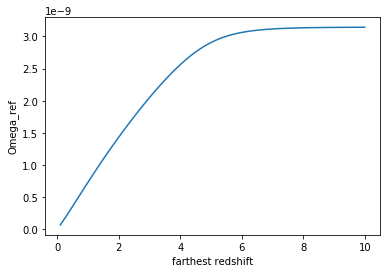

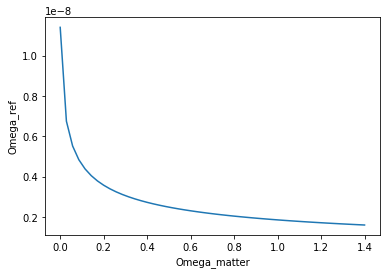

In [267]:
plt.plot(zf_array,Omega_gw_z_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('farthest redshift')
plt.ylabel('Omega_ref')
plt.show()

plt.plot(Omega_m_array,Omega_gw_Omegam_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('Omega_matter')
plt.ylabel('Omega_ref')
plt.show()

## Examining interplay between redshift evolution of rate and mass distributions
find `zp` as a function of `beta_q`, given `Omega_gw_limit` :

To do this, I need to create a grid of `zp` and `beta_q` and compute `Omega_gw` for each point on that grid. Then, I need to find the subspace where `Omega_GW < Omega_gw_limit`

The contour of `Omega_GW == Omega_gw_limit` for a given `alpha` is the function $z_{peak} (\beta_q)$ - so for a given mass distribution and redshift evolution power law params (i.e. $\alpha, \beta$), I can solve for the peak redshift of the rate evolution.

In [269]:
#mass dist params
beta_q_array = np.linspace(-50,50,20)
# gamma_array = np.linspace(-4,4,20)
#z evo params
zp_array = np.linspace(0,5,20)
alpha_arr = np.linspace(-20,20,20)
Omega_gw_bza = np.zeros((len(beta_q_array),len(zp_array),len(alpha_arr)))
for z in range(len(zp_array)): 
    print z 
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 7.]
        for b in range(len(beta_q_array)):
            beta_q = beta_q_array[b]
#         for g in range(len(gamma_array)):
#             gamma = gamma_array[g]
            Omega_gw_bza[b,z,a] = OmegaGW(1000,0.3,fref,massdist=plaw_selection,z_evo_params=z_params)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [270]:
Omega_xr = xr.DataArray(Omega_gw_bza,
                        dims = ('beta_q','zp','alpha'),
                        coords = (gamma_array,zp_array,alpha_arr),
                        name = 'Omega_GW')

In [271]:
Omega_xr.to_netcdf('data/OmegaGW_plaw_selection.nc')

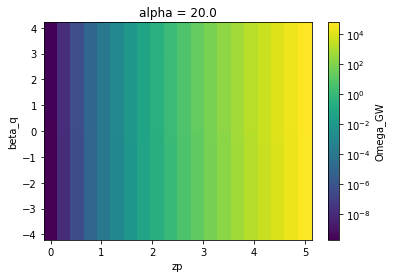

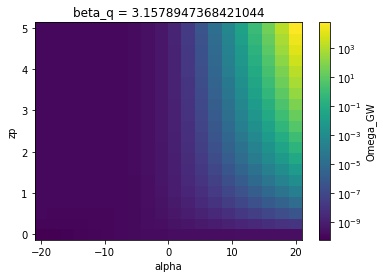

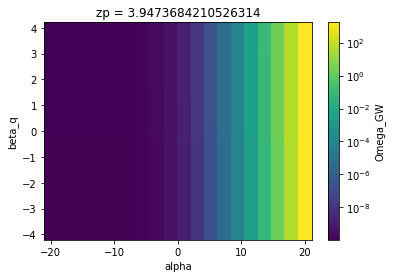

In [287]:
Omega_xr.sel({'alpha':20},method='nearest').plot(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 1-15 OOM (less than 1 for all alpha in range [-20,15])

Omega_xr.sel({'beta_q':3},method='nearest').plot(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 13 OOM over alpha in [-20,20] and 2 OOM over alpha in [-5,5]

Omega_xr.sel({'zp':4},method='nearest').plot(norm=LogNorm())#(norm=LogNorm(vmin=1e-20, vmax=1e45))
plt.show()
#cbar spans 12 OOM over alpha in [-20,20] and 13 OOM over alpha in [-5,5]

looking at the colorbars, alpha seems to have the largest effect, zp has a secondary effect, and beta_q doesn't do much, since changing alpha from -20 to 20 changes Omega_gw by ~13 OOM (keeping beta_q or zp fixed), wheras keeping alpha fixed and changing zp from 0 to 5 and beta_q from -40 to 40 changes Omega_GW by about 1 OOM (although the range of the values for Omega_GW depends heavily on the chosen fixed value of alpha - for example, alpha=20 makes the range of omega gw 15 OOM). This might just be because of the limits ive chosen for them, but the range of zpeak is physically reasonable - the value of the integral shouldnt change much after z ~ O(10) - and the range on beta_q is larger than that on alpha! Therefore, I think the mass distribution (determined by beta_q) has a much smaller effect than the redshift evolution (determined by zp and alpha). I should still probably do this again with more values of alpha over a smaller range.

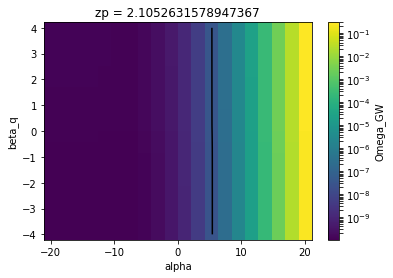

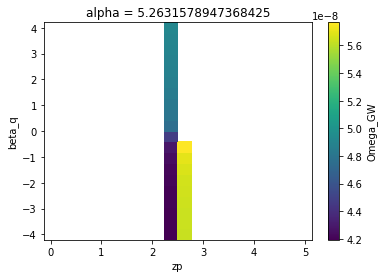

In [289]:
# plot space where omega_Gw is below the limit
Omega_xr.sel(zp=2, method='nearest').plot.imshow(norm=LogNorm())
# Omega_xr.where(Omega_xr.data < OmegaGW_limit).sel(zp=2, method='nearest').plot.contour(cmap='Greys')
Omega_xr.sel(zp=2, method='nearest').plot.contour(levels=[OmegaGW_limit],colors='black')
plt.show()

#plot values where omega_GW is at/near the limit
Omega_xr.where(np.logical_and(Omega_xr.data > OmegaGW_limit-1e-8,
                              Omega_xr.data < OmegaGW_limit+1e-8)
              ).sel(alpha=5,method='nearest').plot() #shouts and murmurs constrains alpha to be ~5 so lets use this for now
plt.show()
#again this shows a much greater ability to constrain the redshift evolution params than the pairing function param:
#contours are basically vertical, only change is for a negative or positive beta_q

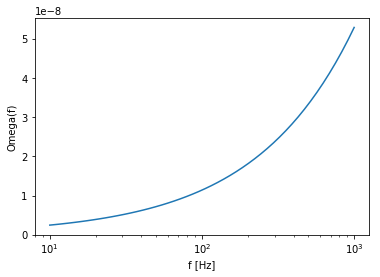

In [8]:
#try to make the fig i always see in astrophysical implications sections of the stochastic papers

# redshift_evolution_parameters = [5.,2.,7.] #zpeak, alpha, beta
f_array = np.logspace(1,3) * u.Hz
Omega_gw_of_f = np.zeros_like(f_array / u.Hz)

for i in range(len(f_array)):
    f=f_array[i]
    Omega_gw_of_f[i] = OmegaGW(10, 0.3, fref=f,massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)

plt.plot(f_array,Omega_gw_of_f)
#plt.axhline(OmegaGW_limit)
plt.xlabel('f [Hz]')
plt.ylabel('Omega(f)')
plt.xscale('log')
# plt.yscale('log')
plt.show()

oh lol obviously its going to be linear on a log-log... im enforcing it to be a power law!

## Remake Figure 2 of Shouts and Murmurs

In [7]:
## actually remake fig 2
# def overlap_reduction(f):
#     """extremely rough (over)estimate, based off of figure 2 in allen+romano"""
#     if f < 75:
#         return -0.89 + 0.89/75 * f
#     else:
#         return 0.2 * np.exp(np.log(2.)/(-100.))
def overlap_reduction(f):
    if f < 250:
        olr = olr_below
    else:
        olr = olr_above
    return np.interp(f,olr[:,0],olr[:,1])

def SNR_integrand(f,z_evo):
    overlap = overlap_reduction(f)
    Omega = OmegaGW(1e3,0.3,f*u.Hz,z_evo_params=z_evo,massdist=equal_masses)
    numerator = (overlap * Omega) **2.
    PH = 1e-45 #np.interp(f,PSDs['# Freq (Hz)'],PSDs['LIGO_Hanford_PSD (1/Hz)'])
    PL = 1e-45 #np.interp(f,PSDs['# Freq (Hz)'],PSDs['LIGO_Livingston_PSD (1/Hz)'])
    denom = (f**6.) * PL * PH #Hz ^ 4
    return numerator/denom
    
def SNR(T,z_evo):
    '''optimal SNR, given by equation 3.61 in Tom's thesis, and eq 8 in S+M'''
    integral = inte.quad(SNR_integrand,10,900,args = z_evo)[0] * (u.s)**4. * u.Hz #Hz^4 in denom and Hz from df
    prefac = (3 * H0**2. / (10 * np.pi**2.))
    return prefac * np.sqrt(2 * T * integral)

#### computationally efficient way

In [38]:
#load in external datasets
olr_below = np.genfromtxt("data/overlap_reduction_below_200hz.csv",delimiter=',')
olr_below=olr_below[:-2]
olr_above=np.genfromtxt("data/overlap_reduction_above_200hz.csv",delimiter=',')

PSD_O1 = pd.DataFrame()
PSD_O1['freq'] = np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,0]
    #strains are the sqrt of the PSD
PSD_O1['Hanford'] = np.power(np.genfromtxt("data/2015_10_24_15_09_43_H1_O1_strain.txt")[:,1],2.) 
PSD_O1['Livingston'] = np.power(np.genfromtxt("data/2015_10_24_15_10_43_L1_O1_strain.txt")[:,1],2.)

PSD_O1_xr = xr.Dataset.from_dataframe(PSD_O1.set_index('freq'))

PSD_O2 = pd.DataFrame()
PSD_O2['freq'] = np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,0]
PSD_O2['Hanford'] =  np.power(np.genfromtxt("data/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt")[:,1],2.)
PSD_O2['Livingston'] =  np.power(np.genfromtxt("data/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt")[:,1],2.)

PSD_O2_xr = xr.Dataset.from_dataframe(PSD_O2.set_index('freq'))


#O1: September 12, 2015 to January 19, 2016
days_in_O1 = (len(pd.date_range(start='09-12-2015',end='01-19-2016',freq='D')) - 14.) * u.day

#O2: November 30, 2016 to August 25, 2017
days_in_O2 = (len(pd.date_range(start='11-30-2016',end='08-25-2017',freq='D')) - 28.) * u.day

# #janky way to enforce 30Msun chirp mas
# m_min = 34.9 
# m_max = 35.0
# Rate = 30.0 /(u.Gpc**3 * u.year)
# gamma = -2.3
massfac = one_chirp_mass() * np.power(u.Msun,5./3)

zp_array = np.linspace(0,5)
alpha_arr = np.linspace(-20,20)
SNR_easy = np.zeros((len(zp_array),len(alpha_arr)))

def overlap_reduction(f):
    if f < 250:
        olr = olr_below
    else:
        olr = olr_above
    return np.interp(f,olr[:,0],olr[:,1])

def f_integrand(f,obs_run):
    overlap = overlap_reduction(f) **2. 
    freq_power = np.power(f,-14./3.)
    if obs_run == 'O1':
        PH = PSD_O1_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O1_xr.sel(freq=f,method='nearest').Livingston
    elif obs_run== 'O2':
        PH = PSD_O2_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O2_xr.sel(freq=f,method='nearest').Livingston
        
    return overlap * freq_power / (PH * PL)

f_integral_O1 = inte.quad(f_integrand, 1.5,6e3,args='O1', limit=200)[0] * (u.s)**3 * (u.Hz)**(4./3)
f_integral_O2 = inte.quad(f_integrand, 1.5,6e3,args='O2', limit=200)[0] * (u.s)**3 * (u.Hz)**(4./3)

In [30]:
f_integrand_arr = (np.power(PSD_O2_xr.freq, -14./3.) * np.interp(PSD_O2_xr.freq,olr_above[:,0],olr_above[:,1]) **2. ) / (PSD_O2_xr.Hanford * PSD_O2_xr.Livingston)
f_integral_O2 = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)
f_integrand_arr = (np.power(PSD_O1_xr.freq, -14./3.) * np.interp(PSD_O1_xr.freq,olr_above[:,0],olr_above[:,1]) **2. ) / (PSD_O1_xr.Hanford * PSD_O1_xr.Livingston)
f_integral_O1 = inte.trapz(f_integrand_arr) * (u.s)**3 * (u.Hz)**(4./3)
# this is an OOM larger than the quad gives 

In [24]:
inte.quad(f_integrand, 1.5,6e3,args='O2', limit=50)
#ok so my error is only 1 OOM less than my result

(2.094134752677902e+84, 5.513076907968815e+82)

In [43]:
Rate = 30.0 /(u.Gpc**3 * u.year)
z_int_arr = np.zeros((len(zp_array),len(alpha_arr)))
for z in range(len(zp_array)):
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 3.]
        pre_snr = ( H0**2. / (10 * np.pi**2.)) #*3.
        
        piG = np.power(np.pi*G,2./3) #/3.
        rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
        z_int = inte.quad(int_over_z,0,1e3,
                         args=(0.3, 0.7,0,z_params[0],
                               z_params[1],z_params[2])
                        )[0]
        z_int_arr[z,a] = z_int
        z_int *= 1./H0
        pre_omega = z_int * Rate * massfac * piG / rhoc2
        
        rho_opt_O1 = pre_snr * pre_omega * np.sqrt(days_in_O1 * f_integral_O1)
        rho_opt_O2 = pre_snr * pre_omega * np.sqrt(days_in_O2 * f_integral_O2)
        rho_opt_tot = rho_opt_O1+rho_opt_O2
        
        SNR_easy[z,a] = rho_opt_tot.to(u.m/u.m)
np.save('data/pre_omega_arr.npy',pre_omega_arr)

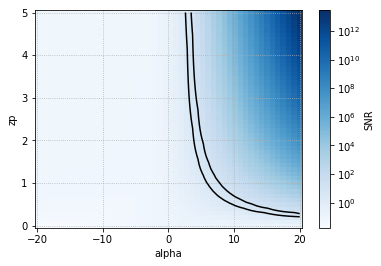

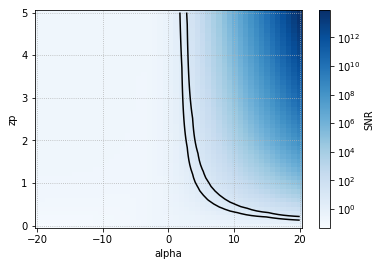

In [44]:
SNR_easy_xr = xr.DataArray(SNR_easy,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')
# SNR_easy_xr.to_netcdf('data/SNR_fig2_one_chirp_mass.nc')
# SNR_easy_xr = xr.open_dataarray('data/SNR_fig2_one_chirp_mass.nc')

SNR_easy_xr.plot(norm=LogNorm(),cmap='Blues') #vmin=1e-2,vmax=1e3
SNR_easy_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

SNR_easy_xr = xr.open_dataarray('data/SNR_fig2_one_chirp_mass.nc')

SNR_easy_xr.plot(norm=LogNorm(),cmap='Blues')
SNR_easy_xr.plot.contour(levels=[3,10],colors='black')
plt.grid(linestyle=':')
plt.show()

### Computationally ineffecient way

In [154]:
olr_below = np.genfromtxt("data/overlap_reduction_below_200hz.csv",delimiter=',')
olr_below=olr_below[:-2]
olr_above=np.genfromtxt("data/overlap_reduction_above_200hz.csv",delimiter=',')
PSDs = pd.read_csv("data/GWTC1_GW150914_PSDs.dat",sep='\t')

#janky way to enforce equal masses with 30 Msun cirp mass
m_min = 34.9 
m_max = 35.0
Rate = 30.0 /(u.Gpc**3 * u.year)
gamma = -2.3

SNR(t_obs,[4.,19.,3.]).to(u.m/u.m)


<Quantity 1.36714431e+12>

In [155]:
#janky way to enforce equal masses with 30 Msun chirp mass
m_min = 34.9 
m_max = 35.0
Rate = 30.0 /(u.Gpc**3 * u.year)

zp_array = np.linspace(0,5,num=20)
alpha_arr = np.linspace(-20,20,num=20)
SNR_za = np.zeros((len(zp_array),len(alpha_arr)))
gamma = -2.3
for z in range(len(zp_array)):
    print z
    for a in range(len(alpha_arr)):
        z_params = [zp_array[z], alpha_arr[a], 3.]
        SNR_za[z,a] = SNR(t_obs,z_params).to(u.m/u.m)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [156]:
SNR_fig2_try = xr.DataArray(SNR_za,
                        dims = ('zp','alpha'),
                        coords = (zp_array,alpha_arr),
                        name = 'SNR')

In [157]:
SNR_fig2_try.to_netcdf('data/SNR_fig2_try.nc')

print(SNR_fig2.max())
SNR_fig2.plot(norm=LogNorm())

<xarray.DataArray 'SNR' ()>
array(4.65118e+82)


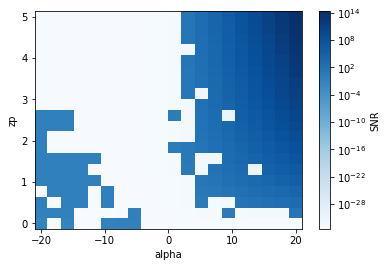

In [185]:
SNR_fig2_try.plot(norm=LogNorm(vmin=1e-2,vmax=1e3),cmap='Blues')
plt.show()

### Sanity Checks and old code

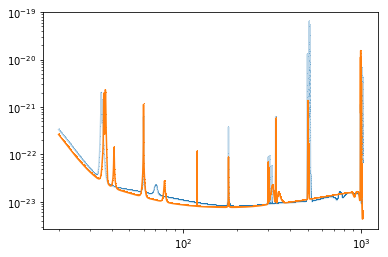

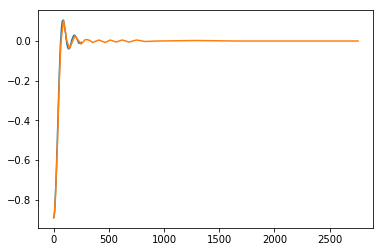

In [17]:
#check out external data
plt.plot(PSDs['# Freq (Hz)'],np.sqrt(PSDs['LIGO_Livingston_PSD (1/Hz)']),marker=',',alpha=0.3)
plt.plot(PSDs['# Freq (Hz)'],np.sqrt(PSDs['LIGO_Hanford_PSD (1/Hz)']),marker=',')
# plt.xlim(10,800)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(olr_below[:,0],olr_below[:,1])
plt.plot(olr_above[:,0],olr_above[:,1])
plt.show()

#todo: plot integrand and see if its approximateable

In [ ]:
#using event-specific PSDs
PSDs_O1 = pd.read_csv("data/GWTC1_GW150914_PSDs.dat",sep='\t')
PSD_O1_xr = xr.Dataset.from_dataframe(PSDs_O1.drop('Unnamed: 3',axis=1
                                            ).set_index('# Freq (Hz)')
                                  ).rename({'# Freq (Hz)':'freq',
                                            'LIGO_Hanford_PSD (1/Hz)':'Hanford',
                                            'LIGO_Livingston_PSD (1/Hz)':'Livingston'})
PSDs_O2 = pd.read_csv("data/GWTC1_GW170814_PSDs.dat",sep='\t')
PSD_O2_xr = xr.Dataset.from_dataframe(PSDs_O2.drop('Virgo_PSD (1/Hz)',axis=1
                                            ).set_index('# Freq (Hz)')
                                  ).rename({'# Freq (Hz)':'freq',
                                            'LIGO_Hanford_PSD (1/Hz)':'Hanford',
                                            'LIGO_Livingston_PSD (1/Hz)':'Livingston'})
def f_integrand(f,obs_run):
    overlap = overlap_reduction(f) **2. 
    freq_power = np.power(f,-14./3.)
    if obs_run == 'O1':
        PH = PSD_O1_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O1_xr.sel(freq=f,method='nearest').Livingston
    elif obs_run== 'O2':
        PH = PSD_O2_xr.sel(freq=f,method='nearest').Hanford
        PL = PSD_O2_xr.sel(freq=f,method='nearest').Livingston
        
    return overlap * freq_power / (PH * PL)

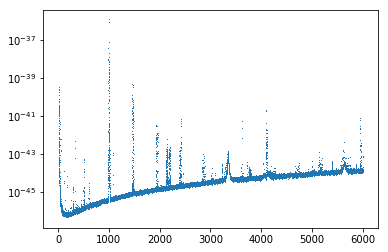

<xarray.DataArray 'freq' ()>
array(6000.)

In [36]:
plt.plot(PSD_O1_xr.freq,PSD_O1_xr.Hanford,marker=',',linewidth=0.0001)

# plt.plot(strain_O1_xr.freq,np.power(strain_O1_xr.Hanford,2))
plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e3-2,1e3+7)
plt.show()
PSD_O1_xr.freq.max()

In [14]:
day_array = np.linspace(50,200)
z_params = [1., 10., 3.]
pre_snr = (3 * H0**2. / (10 * np.pi**2.))

piG = np.power(np.pi*G,2./3)/3.
rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
z_int = inte.quad(int_over_z,0,1e3,
                 args=(0.3, 0.7,0,z_params[0],
                       z_params[1],z_params[2])
                )[0]
z_int *= 1./H0
pre_omega = z_int * Rate * massfac * piG / rhoc2

rho_opt_O1 = pre_snr * pre_omega * np.sqrt(2 * day_array *(u.day) * f_integral_O1)
rho_opt_O2 = pre_snr * pre_omega * np.sqrt(2 * days_in_O2 * f_integral_O2)
rho_opt_tot = rho_opt_O1+rho_opt_O2

SNR = rho_opt_tot.to(u.m/u.m)



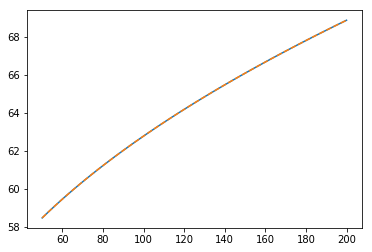

In [113]:
#check if SNR ~ sqrt(T)
import scipy.optimize as opt
plt.plot(day_array,SNR)

def fit(x,a,b):
    return a + np.sqrt(x * b)

popt, pcov = opt.curve_fit(fit,day_array,SNR)
plt.plot(day_array,fit(day_array,*popt),linestyle='--')
plt.show()

#it fits well!